In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from datasets import load_dataset

dataset = load_dataset("cifar10", split="train[:5000]")

In [3]:
dataset

Dataset({
    features: ['img', 'label'],
    num_rows: 5000
})

In [32]:
class NoiseSchedulerV2:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

In [33]:
class NoiseScheduler:
    def __init__(self, num_timesteps=500, device="cuda"):
        self.num_timesteps = num_timesteps
        self.beta_start = 1e-4
        self.beta_end = 0.02
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.num_timesteps).to(device)
        self.alphas = (1.0 - self.betas).to(device)
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0).to(device)
       
    def add_noise(self, image, noise, timesteps):
        self.alphas_cumprod =  self.alphas_cumprod.to(image.device)
        noise = noise.to(image.device)
        timesteps = timesteps.to(image.device)
        
        sqrt_alpha_cumprod = self.alphas_cumprod[timesteps] ** 0.5
        sqrt_one_minus_alpha_cumprod = (1 - self.alphas_cumprod[timesteps]) ** 0.5
        
        sqrt_alpha_cumprod = sqrt_alpha_cumprod.flatten()
        while len(sqrt_alpha_cumprod.shape) < len(x.shape):
            sqrt_alpha_cumprod = sqrt_alpha_cumprod.unsqueeze(-1)

        sqrt_one_minus_alpha_cumprod = sqrt_one_minus_alpha_cumprod.flatten()
        while len(sqrt_one_minus_alpha_cumprod.shape) < len(x.shape):
            sqrt_one_minus_alpha_cumprod = sqrt_one_minus_alpha_cumprod.unsqueeze(-1)
    
        noised_image = sqrt_alpha_cumprod.to(image.device) * image + sqrt_one_minus_alpha_cumprod.to(image.device) * noise.to(image.device)
        return noised_image

In [34]:
from torchvision import transforms
from PIL import Image

preprocess = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["img"]]
    return {"images": images}

dataset.set_transform(transform)

In [35]:
# from diffusers import UNet2DModel

device = "cuda"
# unet = UNet2DModel()

In [77]:
class DownBlock(nn.Module):
    def __init__(self, input_channels, output_channels, embedding_dim):
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.time_embeddings = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                embedding_dim,
                input_channels
            )
        )
        # self.kernel_size = kernel_size
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # nn.Conv2d(output_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        )

    def forward(self, x, t_emb):
        # print(t_emb.shape)
        t = self.time_embeddings(t_emb)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        # print(t.shape)
        # print(x.shape)
        x = x + t
        return self.conv(x)

class UpBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, stride, embedding_dim):
        super().__init__()
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size=kernel_size, stride=stride),
            nn.ReLU(),
        )
        self.time_embeddings = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                embedding_dim,
                input_channels
            )
        )

    def forward(self, x, t_emb):
        t = self.time_embeddings(t_emb)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        x = x + t
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, input_channels, output_channels, num_timesteps, embedding_dim=256):
        super().__init__()
        self.num_timesteps = num_timesteps
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.embedding_dim = embedding_dim
        self.time_embeddings = nn.Embedding(num_timesteps, embedding_dim)

        self.down_blocks = nn.ModuleList([
            DownBlock(self.input_channels, 128, embedding_dim),
            DownBlock(128, 256, embedding_dim),
            DownBlock(256, 512, embedding_dim),
            DownBlock(512, 1024, embedding_dim),
        ])
        self.maxpool =  nn.MaxPool2d(kernel_size=2, stride=2)
        # self.mid_block = nn.Sequential(
        #     nn.Conv2d(1024, 1024, kernel_size=1),
        #     # nn.MaxPool2d(kernel_size=2),
        #     nn.Conv2d(1024, 1024, kernel_size=1),
        #     # nn.MaxPool2d(kernel_size=2),
        #     nn.Conv2d(1024, 1024, kernel_size=1),
        # )
        self.up_blocks = nn.ModuleList([
            UpBlock(1024, 512, 2, 2, embedding_dim),
            UpBlock(512, 256, 2, 2, embedding_dim),
            UpBlock(256, 128, 2, 2, embedding_dim),
            UpBlock(128, 64, 2, 2, embedding_dim),
        ])

        self.out_conv = nn.Conv2d(64, 3, kernel_size=3, padding=1)
        # self.timesteps = nn.Linear(262144, num_timesteps)
        
        
    def forward(self, x, timesteps):
        timesteps = timesteps.to(x.device)
        # print("Initial shape: ", x.shape)
        time_emb = self.time_embeddings(timesteps)
        down_outs = []
        for i, down in enumerate(self.down_blocks):
            x = down(x, time_emb)
            # x = self.maxpool(x)
            down_outs.append(x)
        # print("Down block", x.shape)
        # x = self.mid_block(x)
        # print("Mid block", x.shape)
        down_outs = list(reversed(down_outs))
        # print([d.shape for d in down_outs])
        out_up = x
        for i, up in enumerate(self.up_blocks):

            dout = down_outs[i]
            # print("Out up: ", out_up.shape)
            # print("Dout: ", i, dout.shape)
            out_up = up(out_up + dout, time_emb)
            
        # print("Up block", out_up.shape)
        x = self.out_conv(out_up)
        # print("Out block", x.shape)
        # print(x)
        # timesteps_out = self.timesteps(out_up.reshape(out_up.shape[0], -1))
        
        return x



In [78]:
# class MyUNET(nn.Module):
#     def __init__(self, input_channels, output_channels, num_timesteps):
#         super().__init__()
#         self.unet = model = UNet2DModel(
#             sample_size=64,  # the target image resolution
#             in_channels=3,  # the number of input channels, 3 for RGB images
#             out_channels=3,  # the number of output channels
#             layers_per_block=2,  # how many ResNet layers to use per UNet block
#             block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
#             down_block_types=( 
#                 "DownBlock2D",  # a regular ResNet downsampling block
#                 "DownBlock2D", 
#                 "DownBlock2D", 
#                 "DownBlock2D", 
#                 "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
#                 "DownBlock2D",
#             ), 
#             up_block_types=(
#                 "UpBlock2D",  # a regular ResNet upsampling block
#                 "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
#                 "UpBlock2D", 
#                 "UpBlock2D", 
#                 "UpBlock2D", 
#                 "UpBlock2D"  
#               ),
#         )
#         self.timesteps = nn.Linear(12288, num_timesteps)

#     def forward(self, x, timesteps):
#         timesteps = timesteps.to(x.device)
#         out = self.unet(x, timesteps)
#         # print(out)
#         timesteps_out = self.timesteps(out.sample.reshape(x.shape[0], -1))
#         return out, timesteps_out

In [79]:
# _x = torch.randn(64, 1024, 4, 4).to(device)

In [80]:
# _model = nn.Sequential(
#     # nn.Conv2d(3, 128, 3, padding=1),
#     # nn.MaxPool2d(kernel_size=2, stride=2)
#     nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
#     # nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
#     # nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
#     # nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
#     #  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
#     #  nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
#     # nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),
#     # nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),
#     # nn.AvgPool2d(kernel_size=2)
# ).to(device)
# _model(_x).shape

In [81]:
8 * 64 * 64

32768

In [82]:
3 * 64 * 64

12288

In [83]:
import torch
from torch.optim import Adam
from tqdm.auto import tqdm, trange
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup


train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
num_epochs = 20

device = "cuda"
num_timesteps = 700
model = UNet(3, 3, num_timesteps).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

# noise_scheduler = DDPMScheduler(num_train_timesteps=num_timesteps)
# noise_scheduler = NoiseScheduler(num_timesteps, device)
noise_scheduler = NoiseSchedulerV2(num_timesteps, device=device)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

step = 0

last_n_losses = []
last_n_noise_losses = []
last_n_timestep_losses = []
num_losses_tracked = 100

log_every = 100


with trange(num_epochs, desc="Epoch") as ep:
    for epoch in ep:
        for batch in tqdm(train_dataloader):
            # optimizer.zero_grad()
            
            x = batch["images"].to(device)
            # noise = torch.randn(x.shape).to(x.device)
            bs = x.shape[0]
            # timesteps = torch.randint(0, noise_scheduler.num_timesteps, (bs,), device=x.device).long()
            timesteps = noise_scheduler.sample_timesteps(bs)
            # print(timesteps.shape)
            # noisy_images = noise_scheduler.add_noise(x, noise, timesteps)
            noisy_images, noise = noise_scheduler.noise_images(x, timesteps)
            # print(noisy_images.shape)
            # predicted_noise, predicted_timesteps = model(x, timesteps)
            predicted_noise = model(noisy_images, timesteps)
            # predicted_noise = _model(noisy_image)
            # print(predicted_noise.shape)
            # break
            
            loss = F.mse_loss(predicted_noise, noise)
            
            # timesteps_loss = F.cross_entropy(predicted_timesteps, timesteps.to(device))
            # loss = 0.9 * mse_loss + 0.1 * timesteps_loss
            # loss = mse_loss
            last_n_losses.append(loss.item())
            last_n_losses = last_n_losses[-num_losses_tracked:]

            # last_n_noise_losses.append(mse_loss.item())
            # last_n_noise_losses = last_n_noise_losses[-num_losses_tracked:]
            
            # last_n_timestep_losses.append(timesteps_loss.item())
            # last_n_timestep_losses = last_n_timestep_losses[-num_losses_tracked:]
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            step +=1 
    
            if step % log_every == 0:
                # print(mse_loss)
                avg_loss = sum(last_n_losses) / len(last_n_losses)
                # avg_noise_loss = sum(last_n_noise_losses) / len(last_n_noise_losses)
                # avg_timestep_loss = sum(last_n_timestep_losses) / len(last_n_timestep_losses)
                # ep.set_postfix(avg_loss=avg_loss, avg_noise_loss=avg_noise_loss, avg_timestep_loss=avg_timestep_loss)
                ep.set_postfix(avg_loss=avg_loss)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

In [115]:
model_weights = model.state_dict()

In [112]:
model2 = UNet(3, 3, num_timesteps).to(device)
model2.load_state_dict(model_weights)

<All keys matched successfully>

In [116]:
import torch
from torch.optim import Adam
from tqdm.auto import tqdm, trange
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup


train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
num_epochs = 20

device = "cuda"
num_timesteps = 700
model = UNet(3, 3, num_timesteps).to(device)
model.load_state_dict(model_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# noise_scheduler = DDPMScheduler(num_train_timesteps=num_timesteps)
# noise_scheduler = NoiseScheduler(num_timesteps, device)
noise_scheduler = NoiseSchedulerV2(num_timesteps, device=device)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=100,
    num_training_steps=(len(train_dataloader) * num_epochs),
)

step = 0

last_n_losses = []
last_n_noise_losses = []
last_n_timestep_losses = []
num_losses_tracked = 100

log_every = 100


with trange(num_epochs, desc="Epoch") as ep:
    for epoch in ep:
        for batch in tqdm(train_dataloader):
            # optimizer.zero_grad()
            
            x = batch["images"].to(device)
            # noise = torch.randn(x.shape).to(x.device)
            bs = x.shape[0]
            # timesteps = torch.randint(0, noise_scheduler.num_timesteps, (bs,), device=x.device).long()
            timesteps = noise_scheduler.sample_timesteps(bs)
            # print(timesteps.shape)
            # noisy_images = noise_scheduler.add_noise(x, noise, timesteps)
            noisy_images, noise = noise_scheduler.noise_images(x, timesteps)
            # print(noisy_images.shape)
            # predicted_noise, predicted_timesteps = model(x, timesteps)
            predicted_noise = model(noisy_images, timesteps)
            # predicted_noise = _model(noisy_image)
            # print(predicted_noise.shape)
            # break
            
            loss = F.mse_loss(predicted_noise, noise)
            
            # timesteps_loss = F.cross_entropy(predicted_timesteps, timesteps.to(device))
            # loss = 0.9 * mse_loss + 0.1 * timesteps_loss
            # loss = mse_loss
            last_n_losses.append(loss.item())
            last_n_losses = last_n_losses[-num_losses_tracked:]

            # last_n_noise_losses.append(mse_loss.item())
            # last_n_noise_losses = last_n_noise_losses[-num_losses_tracked:]
            
            # last_n_timestep_losses.append(timesteps_loss.item())
            # last_n_timestep_losses = last_n_timestep_losses[-num_losses_tracked:]
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            step +=1 
    
            if step % log_every == 0:
                # print(mse_loss)
                avg_loss = sum(last_n_losses) / len(last_n_losses)
                # avg_noise_loss = sum(last_n_noise_losses) / len(last_n_noise_losses)
                # avg_timestep_loss = sum(last_n_timestep_losses) / len(last_n_timestep_losses)
                # ep.set_postfix(avg_loss=avg_loss, avg_noise_loss=avg_noise_loss, avg_timestep_loss=avg_timestep_loss)
                ep.set_postfix(avg_loss=avg_loss)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

KeyboardInterrupt: 

0it [00:00, ?it/s]

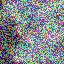

In [120]:
_out = sampleV2(model, noise_scheduler, 2)
Image.fromarray(((_out[0].unsqueeze(0).cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [103]:
from tqdm.auto import tqdm

def sample(model, noise_scheduler, n_samples, img_size, device):
    model.eval()
    with torch.no_grad():
        x = torch.randn(n_samples, *img_size).to(device)
        for i in tqdm(range(num_timesteps, 0, -1)):
            z = torch.randn_like(x).to(device) if i >= 1 else torch.zeros_like(x).to(device)
            t = (torch.ones(n_samples) * i).long().to(device)
            predicted_noise = model(x)

            alpha = noise_scheduler.alphas[t][:, None, None, None]
            alpha_hat = noise_scheduler.alphas_cumprod[t][:, None, None, None]
            beta = noise_scheduler.betas[t][:, None, None, None]

            x = ((1/torch.sqrt(alpha)) * (x - ((1 - alpha)/(torch.sqrt(1 - alpha_hat))) * predicted_noise)) + torch.sqrt(beta) * z

    model.train()
    x = (x.clamp(-1, 1) + 1)/2
    x = (x * 255).type(torch.uint8)
    return x

def sampleV2(model, scheduler, n):
        # logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, scheduler.img_size, scheduler.img_size)).to(scheduler.device)
            for i in tqdm(reversed(range(1, scheduler.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(scheduler.device)
                predicted_noise = model(x, t)
                alpha = scheduler.alpha[t][:, None, None, None]
                alpha_hat = scheduler.alpha_hat[t][:, None, None, None]
                beta = scheduler.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

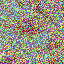

In [96]:
# _out[0].shape
Image.fromarray(((_out[0].unsqueeze(0).cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [15]:
sample_image = dataset[0]["images"].unsqueeze(0)

In [16]:
(torch.ones(5) * 500).long().to(device)

tensor([500, 500, 500, 500, 500], device='cuda:0')

In [17]:
_sam = sample(model, noise_scheduler, 2, (3, 64, 64), device)

  0%|          | 0/400 [00:00<?, ?it/s]

../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [0,0,0], thread: [0,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.
../aten/src/ATen/native/cuda/IndexKernel.cu:92: operator(): block: [0,0,0], thread: [1,0,0] Assertion `-sizes[i] <= index && index < sizes[i] && "index out of bounds"` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [89]:
scheduler.alphas

In [48]:
sample_image.shape

torch.Size([1, 3, 64, 64])

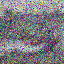

In [128]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [129]:
pred_noise, pred_timestep = model(noisy_image.to(device), timesteps)

In [130]:
ts = pred_timestep.argmax(-1)
ts

tensor([50], device='cuda:0')

In [179]:
alp = scheduler.alphas_cumprod[ts.to(scheduler.alphas_cumprod.device)]


def denoise(noisy_img, alp, n):
    alp = alp.to(noisy_img.device)
    n = n.to(noisy_img.device)
    return (torch.sqrt(1/alp) * noisy_img ) - (torch.sqrt((1/alp) - 1) * n)

In [132]:
noise2 = torch.randn(sample_image.shape)
denoised = denoise(noisy_image.clone(), alp, noise)

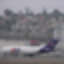

In [133]:
Image.fromarray(((denoised.cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

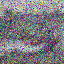

In [134]:
Image.fromarray(((noisy_image.cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

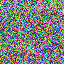

In [184]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([100])
noisy_image = scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [185]:
denoised = noisy_image.clone()
current_timesteps = 100
for _ in range(1):
    pred_noise, pred_timestep = model(denoised.to(device), torch.LongTensor([current_timesteps]))
    ts = pred_timestep.argmax(-1)
    alp = scheduler.alphas_cumprod[ts.to(scheduler.alphas_cumprod.device)]
    # noise2 = torch.randn(sample_image.shape)
    denoised = denoise(denoised, alp, noise)
    current_timesteps -= 1

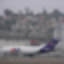

In [186]:
Image.fromarray(((denoised.cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

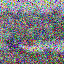

In [42]:
Image.fromarray(((noisy_image.cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [154]:
noisy_image.shape

torch.Size([1, 3, 64, 64])

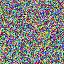

In [187]:
_s_i = torch.randn(1, 3, 64, 64)
noise = torch.randn(_s_i.shape)
timesteps = torch.LongTensor([100])
noisy_image = scheduler.add_noise(_s_i, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [198]:
denoised = noisy_image.clone()
current_timesteps = 100
for _ in range(40):
    pred_noise, pred_timestep = model(denoised.to(device), torch.LongTensor([current_timesteps]))
    ts = pred_timestep.argmax(-1)
    alp = scheduler.alphas_cumprod[ts.to(scheduler.alphas_cumprod.device)]
    # noise2 = torch.randn(sample_image.shape)
    denoised = denoise(denoised, alp, pred_noise.sample.to(device))
    current_timesteps -= 1

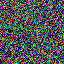

In [199]:
Image.fromarray(((denoised.cpu().permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])